# Gaussian Mixture Models (GMM)

### Description

The Mixture of Gaussian (MoG) or Gaussian Mixture Models (GMM) is a prototypical exmaple of a model where learning is suited to the Expectation Maximization algorithm (EM-Algorithm). The date are described as a weighted sum of K normal distributions
\begin{align}
Pr(X_i|\theta) = \sum_{k=1}^{K} \lambda_k \text{Norm}_{X_i} [\mu_k, \Sigma_k],
\end{align}
where $\mu_{1...K}$ and $\Sigma_{1...K}$ are the means and the covariances of the normal distributions and $\lambda_{1...K}$ are positive valued weights that sum to one.

In the expectation step :
\begin{align}
r_{ik} = \dfrac{\lambda_k \text{Norm}_{X_i} [\mu_k, \Sigma_k]}{\sum_{j=1}^{K} \lambda_j \text{Norm}_{X_i} [\mu_j, \Sigma_j]}
\end{align}

In the Maximization step :
\begin{align}
\begin{cases}
\lambda_k^{[t+1]} = \dfrac{\sum_{i=1}^{K}r_{ik}}{\sum_{j=1}^{K} \sum_{i=1}^{I}r_{ij}},
\\\mu_{k}^{[t+1]} = \dfrac{\sum_{i=1}^{K}r_{ik}X_i}{\sum_{i=1}^{I}r_{ij}},
\\\Sigma_{k}^{[t+1]} = \dfrac{\sum_{i=1}^{K}r_{ik}(X_i - \mu_{k}^{[t+1]})(X_i - \mu_{k}^{[t+1]})^T}{\sum_{i=1}^{I}r_{ij}}.
\end{cases}
\end{align}

This work is a mixture of the efforts of our working group and our academic seniors who helped us with some excerpts from their code and their detailed explanations.

In [1]:
import cv2
import matplotlib.pyplot as plt
from glob import glob
import numpy as np
import imageio
from skimage import img_as_float32
from natsort import natsorted
from skimage.color import rgb2hsv
from scipy.stats import multivariate_normal
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from time import time

#read in data
path_pairs = list(zip(
    natsorted(glob('puzzle_corners_1024x768/images-1024x768/*.png')),
    natsorted(glob('puzzle_corners_1024x768/masks-1024x768/*.png')),
))

imgs = np.array([img_as_float32(imageio.imread(ipath)) for ipath, _ in path_pairs])
msks = np.array([img_as_float32(imageio.imread(mpath)) for _, mpath in path_pairs])

#Resizing images
SCALE = 0.25
imgs = np.array([
    cv2.resize(img, None, fx=SCALE, fy=SCALE)
    for img in imgs
])
msks = np.array([
    cv2.resize(img, None, fx=SCALE, fy=SCALE)
    for img in msks
])

#Ensuring masks are binary
msks[msks>0.5] = 1.
msks[msks<0.5] = 0

C:\Users\abdel\anaconda3\envs\rstudio\lib\site-packages\ipykernel_launcher.py:21: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
C:\Users\abdel\anaconda3\envs\rstudio\lib\site-packages\ipykernel_launcher.py:22: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.


You should consider the following feature sets:
1. RGB pixel value
2. RGB + Difference of Gaussian
3. One other feature set from the previous labs that performed well.

In [2]:
def gaussian_filter(x, y, sigma):
    """Computes 2D Gaussian"""
    return (1 / (2 * np.pi * sigma ** 2)) * np.exp(-1 * (x ** 2 + y ** 2) / (2 * sigma ** 2))

def DoG_filter(x, y, sigma, K):
    """Computes 2D Difference of Gaussian"""
    gaussian = gaussian_filter(x, y, sigma)
    return gaussian - 1 / (2 * np.pi * (K ** 2) * (sigma ** 2)) * np.exp(
        -1 * (x ** 2 + y ** 2) / (2 * (K ** 2) * (sigma ** 2)))

def create_filter(shape, function, sigma, K=None):
    """Creates a 2D Dimensional Convolutional Filter given filter function"""
    if K:
        return np.fromfunction(
            lambda x, y: function(
                x - int(shape[0] / 2), y - int(shape[1] / 2), sigma, K
            ),
            (shape[0], shape[1]),
            dtype=float,)

    return np.fromfunction(
        lambda x, y: function(x - int(shape[0] / 2), y - int(shape[1] / 2), sigma),
        (shape[0], shape[1]),
        dtype=float,)

DoG = create_filter([49, 49], DoG_filter, sigma=3, K=2)

In [3]:
def min_max_stretch(f):
    """Performs a contrast stretch on a given image"""
    a = f.copy()
    if len(f.shape) == 3:
        channels = f.shape[2]
        for i in range(channels):
            a[:, :, i] = (f[:, :, i] - f[:, :, i].min()) / (
                f[:, :, i].max() - f[:, :, i].min()
            )
    else:
        a = (f - f.min()) / (f.max() - f.min())
    return a

In [4]:
rgb_DoG_imgs = []
hsv_imgs = []
for img in imgs:
    hsv = rgb2hsv(img)
    hsv_imgs.append(hsv)
    dog = min_max_stretch(cv2.filter2D(img, -1, DoG))
    rgb_dog = np.dstack((img, dog))
    rgb_DoG_imgs.append(rgb_dog)

In [5]:
rgb_DoG_imgs = np.array(rgb_DoG_imgs)
hsv_imgs = np.array(hsv_imgs)

In [6]:
#splits test set out with the same split as Unet
rgb_imgs_train, rgb_imgs_test, msks_train, msks_test = train_test_split(
    imgs, msks, test_size=0.15, random_state=42)

rgb_DoG_imgs_train, rgb_DoG_imgs_test = train_test_split(rgb_DoG_imgs, test_size=0.15, random_state=42)

hsv_imgs_train, hsv_imgs_test = train_test_split(hsv_imgs, test_size=0.15, random_state=42)

In [9]:
# First Implementation of the GMM

class GaussianMixtureModels:
    
    def __init__(self, k, max_iter=5):
        self.k = k
        self.max_iter = int(max_iter)

    def initialize(self, X):
        self.shape = X.shape
        self.n, self.m = self.shape

        self.Lambda = np.full(shape=self.k, fill_value=1/self.k)
        self.weights = np.full( shape=self.shape, fill_value=1/self.k)
        
        random_row = np.random.randint(low=0, high=self.n, size=self.k)
        self.mu = [ X[row_index,:] for row_index in random_row ]
        self.sigma = [ np.cov(X.T) for _ in range(self.k) ]

    def e_step(self, X):
        # E-Step: update weights (responsability) and Lambda holding mu and sigma constant
        self.weights = self.predict_proba(X)
        self.Lambda = self.weights.mean(axis=0)
    
    def m_step(self, X):
        # M-Step: update mu and sigma holding phi and weights constant
        for i in range(self.k):
            weight = self.weights[:, [i]]
            total_weight = weight.sum()
            self.mu[i] = (X * weight).sum(axis=0) / total_weight
            self.sigma[i] = np.cov(X.T, 
                aweights=(weight/total_weight).flatten(), 
                bias=True)

    def fit(self, X):
        self.initialize(X)
        
        for iteration in range(self.max_iter):
            self.e_step(X)
            self.m_step(X)
            
    def predict_proba(self, X):
        likelihood = np.zeros( (self.n, self.k) )
        for i in range(self.k):
            distribution = multivariate_normal(
                mean=self.mu[i], 
                cov=self.sigma[i])
            likelihood[:,i] = distribution.pdf(X)
        
        numerator = likelihood * self.Lambda
        denominator = numerator.sum(axis=1)[:, np.newaxis]
        weights = numerator / denominator
        return weights
    
    def predict(self, X):
        weights = self.predict_proba(X)
        return np.argmax(weights, axis=1)

In [10]:
# Second Implementation of the GMM

class GMM:
    """
    Gaussian Mixture Model
    
    Varaibles:
    K : The Number of components in the mixture
    lambd: Array of weightings for each mixture in the model
    mean: Mean Array of the GMM
    cov: Covariance matrix of the GMM
    prevent_singular: A matrix used prevent cov being singular
    
    """
    def __init__(self, K, num_features):
        self.K = K
        self.lambd = np.ones(K)/K
        
        self.num_features = num_features
        self.mean = np.random.random((K, num_features))
        
        self.cov = np.random.random((K,num_features,num_features))

        self.prevent_singular = np.zeros((K,num_features,num_features))
        
        #ensure cov is postive definite
        for k in range(K):
            self.prevent_singular[k] = 1e-7*np.eye(num_features)
            self.cov[k] *= self.cov[k].T
            self.cov[k] += 1e+4*np.eye(num_features)
    
    def expectation(self, X):
        """Calculates responsibility R that each distribution takes for each data point in X"""
        R = []
        for k in range(self.K):
            
            #calculate gaussian response of each component of the GMM
            r_k_numerator = self.lambd[k]*multivariate_normal(mean = self.mean[k], cov=self.cov[k]).pdf(X)
            R.append(r_k_numerator)
        
        R = np.array(R).T 
        log_likelihood =  np.sum(np.log(np.sum(R, axis = 1)))
        
        #divide by sum of all component's response
        R = R/(R.sum(axis = 1, keepdims = 1))
        
        return R, log_likelihood
    
    
    def maximisation(self, X, R):
        """Updates GMM variables given expectation"""
        sum_r_ik = np.sum(R, axis = 0)
        self.lambd = sum_r_ik/np.sum(R)
        
        self.mean = R.T @ X / sum_r_ik.reshape(-1,1)
        
        for k in range(self.K):
            self.cov[k] = (R[:,k]*(X - self.mean[k]).T @ (X - self.mean[k])) / sum_r_ik[k]
            
            #ensure cov is not singular
            self.cov = np.nan_to_num(self.cov) + self.prevent_singular
    
    def fit(self, X, max_iters, min_iters, converg_val):
        """Fits GMM to given data X"""
        log_likelihood = 0 
        for i in range(max_iters):
            old_log_likelihood = log_likelihood
            R , log_likelihood = self.expectation(X)
            self.maximisation(X,R)
            change = np.abs(old_log_likelihood - log_likelihood)
            if change < converg_val and i > min_iters:
                #break if convergence is met
                break
                
    
    def predict(self, X):
        """Predict a probabilty distribution of values in X belonging to the GMM"""
        summ=0 
        for k in range(self.K):
            summ += self.lambd[k]*multivariate_normal(mean = self.mean[k], cov=self.cov[k]).pdf(X)
        return summ
    
    def predict_single_component(self, X, k):
        """Predict a probabilty distribution of values in X belonging to a single distribution within the GMM"""
        return self.lambd[k]*multivariate_normal(mean = self.mean[k], cov=self.cov[k]).pdf(X)

In [11]:
def k_fold_cv(X, num_folds = 5, shuffle = False, random_seed = 42):
    """returns an array containing a specified number of folds. Each fold contains indexes of images. 
    Each fold is unique and does not contain any indexes from other folds"""
    if shuffle:
        np.random.seed(seed = random_seed)
        idxs = np.random.permutation(X.shape[0])
    else:
        idxs = np.arange(X.shape[0])
    
    folds = np.array_split(idxs, num_folds)
    
    return folds
    
def get_train_val_idx(folds, val_fold_num):
    """returns train and validation split indexes given number of the fold that should be used for validation"""
    val_idx = folds[val_fold_num]
    
    train_idx = np.array([0])   
    for i in range(len(folds)):
        if i != val_fold_num:
            train_idx = np.append(train_idx, folds[i])
    
    train_idx = train_idx[1:]
    
    return train_idx, val_idx

In [12]:
def train(X,y, lambd=0.4, num_gaussians_back = 4, num_gaussians_fore = 4):
    """trains a puzzle piece segmentation model"""
    gmm_back = GMM(num_gaussians_back, X.shape[1])
    gmm_back.fit(X[y<0.5], max_iters = 100, min_iters = 10, converg_val = 2) 
    
    gmm_fore = GMM(num_gaussians_fore, X.shape[1])
    gmm_fore.fit(X[y>0.5], max_iters = 100,  min_iters = 10, converg_val = 2)
    
    return gmm_back, gmm_fore

In [13]:
def dice(y_true, y_pred):
    """Calculates Dice Coefficeint given predictions and labels"""
    y_true = np.asarray(y_true).astype(bool)
    y_pred = np.asarray(y_pred).astype(bool)

    im_sum = y_true.sum() + y_pred.sum()

    # Compute Dice coefficient
    intersection = np.logical_and(y_true, y_pred)

    return 2. * intersection.sum() / im_sum

def pixel_accuracy(y_true, y_pred):
    """Calculates Pixel Accuracy given predictions and labels"""
    y_true = np.asarray(y_true).astype(np.uint8).flatten()
    y_pred = np.asarray(y_pred).astype(np.uint8).flatten()
    return accuracy_score(y_true, y_pred)


def iou(y_true, y_pred):
    """Calculates IoU score given predictions and labels"""
    y_true = np.asarray(y_true).astype(bool)
    y_pred = np.asarray(y_pred).astype(bool)
    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

def roc_auc(y_true, y_pred):
    """RoC-AuC score given predictions and labels"""
    y_true = np.asarray(y_true).astype(bool).flatten()
    y_pred = np.asarray(y_pred).astype(bool).flatten()
    return roc_auc_score(y_true, y_pred)

In [14]:
def plot_predictions(y_pred, plot_name=None, save=False): 
    """Plots image mask predictions"""
    fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10, 10))
    ax = axes.flatten()
    for i in range(y_pred.shape[0]):
        ax[i].imshow(y_pred[i], cmap="gray")
        ax[i].axis("off")
    plt.tight_layout()
    if save:
        plt.savefig(f"{plot_name}.png")
    plt.show()

In [15]:
#Grid Search of Hyperparameters
num_folds = 5
folds = k_fold_cv(rgb_imgs_train,num_folds = num_folds)
lambd = 0.4

train_sets = ['rgb', 'rgb_dog', 'hsv']
num_components = [2,3,4]

fold_hyps = []

for i in range(num_folds):
    runs = []
    for dataset in train_sets:
        for num_gaussians_fore in num_components:
            for num_gaussians_back in num_components:
            
                if dataset == 'rgb':
                    train_set = rgb_imgs_train
                elif dataset == 'rgb_dog':
                    train_set = rgb_DoG_imgs_train
                else:
                    train_set = hsv_imgs_train
            
                train_idx, val_idx = get_train_val_idx(folds, val_fold_num = i)

                imgs_train_fold = train_set[train_idx].reshape(-1,train_set.shape[3])
                msks_train_fold = msks_train[train_idx].reshape(-1)

                imgs_val_fold = train_set[val_idx].reshape(-1,train_set.shape[3])
                msks_val_fold = msks_train[val_idx].reshape(-1)

                gmm_back, gmm_fore = train(imgs_train_fold,msks_train_fold, num_gaussians_fore=num_gaussians_fore, 
                               num_gaussians_back=num_gaussians_back)
                
                back = gmm_back.predict(imgs_val_fold)
                fore = gmm_fore.predict(imgs_val_fold)
                
                y_prob = (lambd * fore) / ((lambd * fore) + ((1 - lambd) * back))

                y_pred = (y_prob>0.5).astype(np.float32)
                dice_val = dice(msks_val_fold, y_pred)
                accuracy = pixel_accuracy(msks_val_fold, y_pred)
                iou_val = iou(msks_val_fold, y_pred)
                
                hyps = [dataset, num_gaussians_fore, num_gaussians_back]
                results = [dice_val, accuracy, iou_val]
                run = {'hyps':hyps, 'results': results}
                print(run)
                runs.append(run)
    fold_hyps.append(runs)
                

{'hyps': ['rgb', 2, 2], 'results': [0.8483062689313394, 0.9094619750976562, 0.7365727936577315]}
{'hyps': ['rgb', 2, 3], 'results': [0.8306016496228281, 0.8969319661458334, 0.7102811880613052]}
{'hyps': ['rgb', 2, 4], 'results': [0.8289915608217543, 0.8962783813476562, 0.7079296212446586]}
{'hyps': ['rgb', 3, 2], 'results': [0.8455179910859876, 0.9085744222005209, 0.7323786638142086]}
{'hyps': ['rgb', 3, 3], 'results': [0.8280537985445148, 0.8961359659830729, 0.7065629783313626]}
{'hyps': ['rgb', 3, 4], 'results': [0.8249942474369135, 0.8942896525065104, 0.7021193263414421]}
{'hyps': ['rgb', 4, 2], 'results': [0.8492339665643542, 0.9109954833984375, 0.7379727432768773]}
{'hyps': ['rgb', 4, 3], 'results': [0.8320051221854659, 0.8987528483072916, 0.7123362764588937]}
{'hyps': ['rgb', 4, 4], 'results': [0.8296934627953692, 0.8975118001302084, 0.708953967545253]}
{'hyps': ['rgb_dog', 2, 2], 'results': [0.8545336747601271, 0.9144846598307291, 0.7460137901314372]}
{'hyps': ['rgb_dog', 2, 3],

In [16]:
#Averaging results from each fold
fold_hyps_avg = []
for runs in fold_hyps[0]:
    fold_hyps_avg.append({'hyps': runs['hyps'], 'results': np.array(runs['results'])/5})

for i in range(1, len(fold_hyps)):
    for j in range(len(fold_hyps[i])):
        fold_hyps_avg[j]['results'] += np.array(fold_hyps[i][j]['results'])/5

In [17]:
#find hyperparameters that perform best based on each metric
highest_dice = fold_hyps_avg[0]
highest_accuracy = fold_hyps_avg[0]
highest_iou = fold_hyps_avg[0]
for hyps in fold_hyps_avg:
    if hyps['results'][0]>highest_dice['results'][0]:
        highest_dice = hyps
    if hyps['results'][1]>highest_accuracy['results'][1]:
        highest_accuracy = hyps
    if hyps['results'][2]>highest_iou['results'][2]:
        highest_iou = hyps

In [18]:
print(highest_dice)
print(highest_accuracy)
print(highest_iou)

{'hyps': ['hsv', 2, 3], 'results': array([0.95284642, 0.97555593, 0.91057313])}
{'hyps': ['hsv', 2, 3], 'results': array([0.95284642, 0.97555593, 0.91057313])}
{'hyps': ['hsv', 2, 3], 'results': array([0.95284642, 0.97555593, 0.91057313])}


In [19]:
#flattening images for training
hsv_imgs_train_flat = hsv_imgs_train.reshape(-1,hsv_imgs_train.shape[3])
msks_train_flat = msks_train.reshape(-1)
hsv_imgs_test_flat = hsv_imgs_test.reshape(-1,hsv_imgs_test.shape[3])
msks_test_flat = msks_test.reshape(-1)

In [20]:
#training the final GMM model
start = time()
gmm_back, gmm_fore = train(hsv_imgs_train_flat,msks_train_flat, num_gaussians_fore = 3, 
               num_gaussians_back = 3)
train_time = time() - start 

In [21]:
#Validation
start = time()
back = gmm_back.predict(hsv_imgs_test_flat)
fore = gmm_fore.predict(hsv_imgs_test_flat)

lambd =0.4
#calculating the probaility of each pixel being in the foreground
y_prob = (lambd * fore) / ((lambd * fore) + ((1 - lambd) * back))

#thresholding the probabilities
y_pred = (y_prob>0.5).astype(np.float32)
inference_time = time() - start 

#reshaping predictions back to original image shape
predicted_images = y_pred.reshape(msks_test.shape)

#evaluation
dice_val = dice(msks_test_flat, y_pred)
accuracy = pixel_accuracy(msks_test_flat, y_pred)
iou_val = iou(msks_test_flat, y_pred)
roc_auc_val = roc_auc(msks_test_flat, y_pred)

results of GMM on test set:
dice:  0.9763019767717948
accuracy:  0.9872945149739584
Intersection of Union:  0.9537011448874851
ROC AUC:  0.9816904467617139
Training time:  40.55283308029175
Inference time:  0.1665959358215332


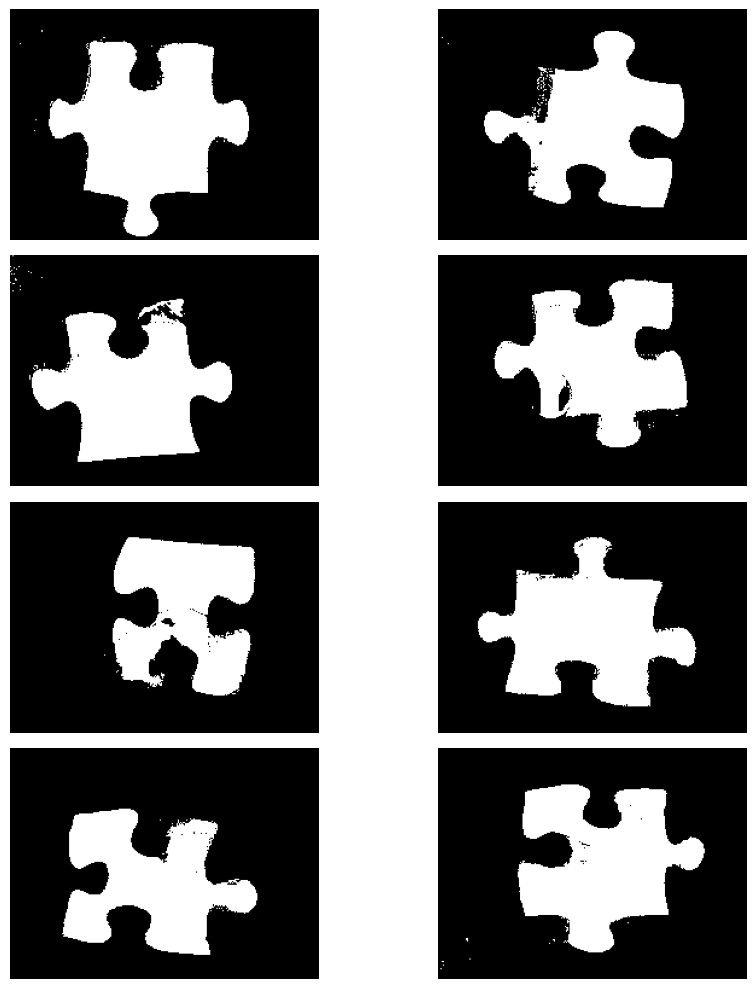

In [22]:
print('results of GMM on test set:')
print('dice: ',dice_val)
print('accuracy: ', accuracy)
print('Intersection of Union: ',iou_val)
print('ROC AUC: ',roc_auc_val)
print('Training time: ', train_time)
print('Inference time: ', inference_time)
plot_predictions(predicted_images)

In [23]:
def train_old_model(X,y):
    """Fits a Single Normal distibutions to background pixels of the images and another to foreground pixels"""
    back_X = X[y<0.5]
    fore_X = X[y>0.5]
    
    back_mean = back_X.mean(axis=0)
    back_cov = np.cov(back_mean)
    
    fore_mean = fore_X.mean(axis=0)
    fore_cov = np.cov(fore_mean)
    

    return back_mean, back_cov, fore_mean, fore_cov

In [24]:
start = time()
#train previous model
back_mean, back_cov, fore_mean, fore_cov = train_old_model(hsv_imgs_train_flat,msks_train_flat)

train_time_old = time() -start

In [25]:
#Validation
start = time()

back = multivariate_normal.pdf(hsv_imgs_test_flat, back_mean, back_cov, allow_singular=True)
fore = multivariate_normal.pdf(hsv_imgs_test_flat, fore_mean, fore_cov, allow_singular=True)

lambd =0.4
#calculating the probaility of each pixel being in the foreground
y_prob = (lambd * fore) / ((lambd * fore) + ((1 - lambd) * back))

#thresholding the probabilities
y_pred = (y_prob>0.5).astype(np.float32)

inference_time_old = time() -start

preds = y_pred.reshape(msks_test.shape)
#evaluation
dice_val = dice(msks_test_flat, y_pred)
accuracy = pixel_accuracy(msks_test_flat, y_pred)
iou_val = iou(msks_test_flat, y_pred)
roc_auc_val = roc_auc(msks_test_flat, y_pred)

In [26]:
print('results of previous single gaussian method on test set:')
print('dice: ',dice_val)
print('accuracy: ', accuracy)
print('Intersection of Union: ',iou_val)
print('ROC AUC: ',roc_auc_val)
print('Training time: ', train_time_old)
print('Inference time: ', inference_time_old)

results of previous single gaussian method on test set:
dice:  0.9008371745085313
accuracy:  0.9554367065429688
Intersection of Union:  0.8195666316368914
ROC AUC:  0.9101872666954045
Training time:  0.06779718399047852
Inference time:  0.047976016998291016


### Limitations


All unsupervised learning methods known today share certain limitations.

First, they tend to rely on the researcher choosing certain arbitrary complexity parameters such as the number of clusters k. Worse still, while there are techniques for picking these complexity parameters, they are heuristic and often unsatisfying in practice. It can be very hard to tell if an unsupervised learning method is “overfitting”, because “overfit” doesn’t even have a precise definition for unsupervised learning problems.

Second, there are no hard metrics like accuracy or AUC that let you compare models across different families. While each unsupervised learning algorithm will have its own internal metrics which they try to optimize such as variance explained or perplexity, these usually can’t be meaningful compare two models that use two different algorithms or with different complexity parameters. This makes model selection a fundamentally subjective task - to decide that, say, t-SNE is doing a better job than k-means on a given data set, the modeler is often reduced to eyeballing the output.

Third and finally, the factors and/or clusters discovered by unsupervised learning algorithms are often unsatisfying or counter-intuitive and don’t necessarily line up with human intuition. Another way of saying the same thing is that if a human goes through and creates labels Y for the training set X after the unsupervised learning algorithm has been applied to it, they are not very likely to come up with the same factors or clusters. In general, humans tend to come up with rules that “make sense” but don’t explain as much variance as possible, while algorithms tend to find “deep” features that do explain a lot of variance but have complicated definitions that are hard to make sense of.

These seem like serious criticisms; does this mean we shouldn’t use unsupervised learning? We won’t tell you that you categorically should never use it, but we should know what we’re getting into. By default, it tends to produce low-quality, hard-to-interpret models that cannot really be defended due to number of subjective decisions needed to make them work at all.

On the other hand, unsupervised learning can be extremely helpful during exploratory research; also, in the form of representation learning, it can sometimes accelerate learning or improve performance, or allow models to generalize from an extremely limited labeled training set. For example, a sentiment analysis model trained on only a few hundred reviews may only see the word “sterling” once, but if it uses a word embedding model like Word2Vec, it will understand that “stupendous” is broadly a synonym for “good” or “great”, and will therefore be able to correctly classify a future example with the word “stupendous” - which did not appear even once in the training set - as likely having positive sentiment. While success stories like this are possible, in general unsupervised learning requires more expertise, more manual tuning, and more input from domain experts in order to create value, when compared to supervised learning projects.

Unfortunately, we do not always have the labels necessary for supervised learning, and the datasets available may be too large, too high dimensional, or too sparse to be amenable to traditional techniques; it is in these situations where the benefits of unsupervised learning can outweigh the negatives.

### Conclusion


In this work We discussed a method for posing an unsupervised learning problem as an maximum likelihood optimization, and described and implemented the EM algorithm often used to solve these otherwise intractable problems. We made the EM algorithm concrete by implementing one particular latent variable model, the Gaussian mixture model, a powerful unsupervised clustering algorithm. We’ve seen first hand that the clusters identified by GMMs don’t always line up with what we believe the true structure to be; this lead to a broader discussion of the limitations of unsupervised learning algorithms and the difficulty getting value out of them.

Could we use dimensionality reduction algorithm to perform better ?